In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as spio
from scipy.stats import pearsonr
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
from math import sqrt

import tensorflow as tf
import copy

tf.keras.backend.set_floatx('float32')

2024-02-04 18:57:58.633912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2024-02-04 18:58:00.083728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-04 18:58:00.090020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-04 18:58:00.090216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
tf.random.set_seed(1337)
np.random.seed(3117)

def normalize(x):
    xmin = tf.reduce_min(x, axis=[-2, -1])
    xmax = tf.reduce_max(x, axis=[-2, -1])
    normalized = (x - xmin[..., None, None]) / (xmax - xmin)[..., None, None] 
    return normalized, xmin, xmax

def unnormalize(args):
    x, xmin, xmax = args
    return (x * (xmax - xmin)[..., None, None]) + xmin[..., None, None]
    
len_ = 400

def mkmodel():
    tf.random.set_seed(99997)
    x = tf.keras.layers.Input(name='x', shape=(len_,1))
    x_norm, xmin, xmax = tf.keras.layers.Lambda(normalize)(x)

    y = tf.keras.layers.Conv1D(64, kernel_size=31, strides = 1, activation='linear', input_shape=(len_,1), padding="same", use_bias=False)(x_norm) #15
    y = tf.keras.layers.MaxPooling1D(pool_size=5, strides = 1, padding="same")(y)
    y = tf.keras.layers.BatchNormalization()(y)
    ys = tf.keras.layers.Activation(activation='elu')(y)

    y = tf.keras.layers.Conv1D(64, 7, padding='same', dilation_rate=2)(ys)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation(activation='relu')(y)
    y = tf.keras.layers.SeparableConv1D(64, kernel_size=31, strides = 1, activation='relu', padding="same")(y) 
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation(activation='elu')(y) 
    yc = tf.keras.layers.Conv1D(1, kernel_size=21, activation='sigmoid', padding="same", name='cls_norm')(y) #11
    yb = tf.keras.layers.SeparableConv1D(64, kernel_size=15, strides = 1, activation='relu', padding="same")(ys) 
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(yb)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation(activation='relu')(y)
    y = tf.keras.layers.Concatenate()([
        y, 
        tf.keras.layers.Conv1D(128, kernel_size=21, padding="same", activation="elu")(yb)
    ])
    y = tf.keras.layers.Conv1DTranspose(128, kernel_size=21, strides=1, activation='elu', padding="same")(y)
    yr = tf.keras.layers.Conv1D(1, kernel_size=21, activation='elu', padding="same", name="reg_norm")(y) #11
    yr = tf.keras.layers.Lambda(unnormalize, name='reg')([yr, xmin, xmax])
    yo = tf.keras.layers.Concatenate(name='y', axis=-1)([yc, yr])
    model = tf.keras.Model(inputs=[x], outputs=[yo])
    return model
model = mkmodel()
model.summary()

2024-02-04 18:58:01.421606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-04 18:58:01.421933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-04 18:58:01.422070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x (InputLayer)                 [(None, 400, 1)]     0           []                               
                                                                                                  
 lambda (Lambda)                ((None, 400, 1),     0           ['x[0][0]']                      
                                 (None,),                                                         
                                 (None,))                                                         
                                                                                                  
 conv1d (Conv1D)                (None, 400, 64)      1984        ['lambda[0][0]']                 
                                                                                              

2024-02-04 18:58:02.386453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-02-04 18:58:02.412689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-04 18:58:02.413424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [4]:
def prepare_y_vector(y_data):
    y_one_hot_cls = np.zeros((y_data.shape[0], len_, 1))
    y_one_hot_reg = np.zeros((y_data.shape[0], len_, 1))

    for i in range(y_data.shape[0]):
        y_one_hot_cls[i, int(y_data[i, 0])-1, 0] = 1.
        y_one_hot_reg[i, int(y_data[i, 0])-1, 0] = y_data[i, 1]
        y_one_hot_cls[i, int(y_data[i, 2])-1, 0] = 1.
        y_one_hot_reg[i, int(y_data[i, 2])-1, 0] = y_data[i, 3]
    y_one_hot = np.concatenate([y_one_hot_cls, y_one_hot_reg], axis=-1)
    return y_one_hot


def decode_output(y_pred):
    out = np.zeros([y_pred.shape[0], 4])
    for bn in range(y_pred.shape[0]):
        b = copy.copy(y_pred[bn, 20:-20, :]) # (360, 2)
        m1 = np.argmax(b[:, 0])
        s1 = b[m1, 1]
        zeros_range = 25 #13
        for i in range(zeros_range):
            iz = m1-zeros_range//2 + i
            if 0 < iz < b.shape[0]:
                b[iz, 0] = 0
        m2 = np.argmax(b[:, 0])
        s2 = b[m2, 1]
        m1 += 20
        m2 += 20
        if m2 > m1:
            out[bn, :] = np.array([m1+1, s1, m2+1, s2]) #+1 zgodność z y_train, y_test - położenie piku
        else:
            out[bn, :] = np.array([m2+1, s2, m1+1, s1])
    return out


def loss(y_true, y_pred):
    cls_ce = tf.losses.binary_crossentropy(y_true[..., 0], y_pred[..., 0])
    reg = y_true[..., 0] * tf.math.squared_difference(y_true[..., 1], y_pred[..., 1])
    reg_s = tf.reduce_sum(reg, axis=[-1])
    reg_s = tf.cast(reg_s, tf.float32)
    return 1. * cls_ce + 10. * reg_s


def loss_h(y_true, y_pred):
    cls_ce = tf.losses.binary_crossentropy(y_true[..., 0], y_pred[..., 0]) + tf.losses.hinge(y_true[..., 0], (y_pred[..., 0] * 1.5) - 0.75)
    reg = y_true[..., 0] * tf.math.squared_difference(y_true[..., 1], y_pred[..., 1])
    reg_s = tf.reduce_sum(reg, axis=[-1])
    reg_s = tf.cast(reg_s, tf.float32)
    return 1. * cls_ce + 10. * reg_s

def loss_old(y_true, y_pred):
    cls_ce = tf.losses.binary_crossentropy(y_true[..., 0], y_pred[..., 0])
    cls_h = tf.losses.hinge(y_true[..., 0], y_pred[..., 0]) - 0.99
    
    reg = y_true[..., 0] * tf.math.squared_difference(y_true[..., 1], y_pred[..., 1])
    reg_s = tf.reduce_sum(reg, axis=[-1])
    reg_s = tf.cast(reg_s, tf.float32)
    return 1. * cls_h + 1. * cls_ce + 10. * reg_s 
    #return tf.reduce_sum(10. * cls_h + 1. * cls_ce + 5. * reg_s)  #1 1 5

In [5]:
def test_model(test_model, dataset, dataset_name):
    X_train, y_train = dataset
    print(f'{dataset_name} DATASET');
    pred_train = test_model.predict(X_train)
    pred_train = decode_output(pred_train)
    txts = ['P1', 'H1', 'P2', 'H2']
    for i in range(4):
      t = txts[i]
      print(f'{t} RMSEC:', np.sqrt(mean_squared_error(y_train[:,i],pred_train[:,i])))
      corr,_ = pearsonr(y_train[:,i],pred_train[:,i])
      print(f' {t} R^2:', corr**2)

    plt.figure(figsize=(20,5))
    for i in range(4):
      plt.subplot(1,4,i+1)
      plt.scatter(y_train[:,i], pred_train[:,i])
      plt.plot([y_train[:,i].min(), y_train[:,i].max()], [y_train[:,i].min(), y_train[:,i].max()], 'k--', lw=1)
      if((i==0) or (i==2)):
        plt.xlabel('Peak location measured')
        plt.ylabel('Peak location predicted')
      else :
        plt.xlabel('Peak height measured')
        plt.ylabel('Peak height predicted')
    plt.show()

    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.scatter(y_train[:,2]-y_train[:,0], pred_train[:,2]-pred_train[:,0], color='g')
    plt.plot([0,130],[0,130], 'k--', lw=1)
    plt.xlabel('Difference measured')
    plt.ylabel('Difference predicted')

    plt.subplot(1,4,3)
    plt.scatter(y_train[:,1]/y_train[:,3], pred_train[:,1]/pred_train[:,3], color='g')
    plt.plot([0,12],[0,12], 'k--', lw=1)
    plt.xlabel('Peak ratio measured')
    plt.ylabel('Peak ratio predicted')
    plt.show()

In [6]:
mat = spio.loadmat('volt_sim_noise0.mat')# (1)
X = mat['X']
y = mat['y']
X = np.expand_dims(X, axis=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

y_train_hot = prepare_y_vector(y_train)
y_val_hot = prepare_y_vector(y_val)


In [7]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.7, beta_2=0.9, decay=0.001) 

model.compile(loss={'y': loss},
              optimizer=opt,
              run_eagerly=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    mode='min'
)
mcp_save = tf.keras.callbacks.ModelCheckpoint('best.tf', save_format='tf', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=0.00005, min_delta=1e-4, mode='min')

In [14]:
tf.random.set_seed(1337)
mymodel=model.fit(
    X_train,
    y_train_hot,
    batch_size=64,
    epochs=100,
    verbose=1,
    validation_data=(X_val,y_val_hot),
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss] 
)

Epoch 1/100


2023-12-29 15:51:58.813885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-29 15:51:58.814804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-29 15:51:58.815651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

684/684 [==============================] - ETA: 0s - loss: 1798.9330

2023-12-29 15:52:47.012814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-29 15:52:47.013634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-29 15:52:47.014419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

684/684 [==============================] - 51s 69ms/step - loss: 1798.9330 - val_loss: 66.3992 - lr: 0.0010
Epoch 2/100
684/684 [==============================] - 47s 68ms/step - loss: 8.6101 - val_loss: 3.1404 - lr: 0.0010
Epoch 3/100
684/684 [==============================] - 47s 68ms/step - loss: 3.6620 - val_loss: 3.2347 - lr: 0.0010
Epoch 4/100
684/684 [==============================] - 47s 68ms/step - loss: 2.4677 - val_loss: 4.8966 - lr: 0.0010
Epoch 5/100
684/684 [==============================] - 47s 68ms/step - loss: 1.7713 - val_loss: 3.4614 - lr: 0.0010
Epoch 6/100
684/684 [==============================] - 47s 68ms/step - loss: 1.2981 - val_loss: 2.4752 - lr: 0.0010
Epoch 7/100
684/684 [==============================] - 47s 68ms/step - loss: 1.0006 - val_loss: 1.6420 - lr: 0.0010
Epoch 8/100
684/684 [==============================] - 47s 68ms/step - loss: 0.7832 - val_loss: 0.6898 - lr: 0.0010
Epoch 9/100
684/684 [==============================] - 47s 68ms/step - loss: 0.6

In [16]:
tf.random.set_seed(1337)
mymodel=model.fit(
    X_train,
    y_train_hot,
    batch_size=64,
    epochs=100,
    verbose=1,
    validation_data=(X_val,y_val_hot),
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss] 
)

Epoch 1/100
684/684 [==============================] - 47s 69ms/step - loss: 0.0528 - val_loss: 0.0816 - lr: 0.0010
Epoch 2/100
684/684 [==============================] - 47s 68ms/step - loss: 0.0533 - val_loss: 0.1157 - lr: 0.0010
Epoch 3/100
684/684 [==============================] - 47s 68ms/step - loss: 0.0479 - val_loss: 0.0968 - lr: 0.0010
Epoch 4/100
684/684 [==============================] - 47s 68ms/step - loss: 0.0519 - val_loss: 0.0946 - lr: 0.0010
Epoch 5/100
684/684 [==============================] - 47s 68ms/step - loss: 0.0470 - val_loss: 0.0876 - lr: 0.0010
Epoch 6/100
684/684 [==============================] - 47s 68ms/step - loss: 0.0470 - val_loss: 0.1187 - lr: 0.0010
Epoch 7/100
684/684 [==============================] - 47s 68ms/step - loss: 0.0445 - val_loss: 0.0434 - lr: 0.0010
Epoch 8/100
684/684 [==============================] - 47s 68ms/step - loss: 0.0455 - val_loss: 0.0462 - lr: 0.0010
Epoch 9/100
684/684 [==============================] - 47s 68ms/step - l

TRAIN SET DATASET


2023-12-30 09:08:29.120567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-30 09:08:29.122081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-30 09:08:29.122767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1367/1367 [==============================] - 30s 19ms/step
P1 RMSEC: 0.0
 P1 R^2: 1.0
H1 RMSEC: 0.016647604127262773
 H1 R^2: 0.9999650214317073
P2 RMSEC: 0.0
 P2 R^2: 1.0
H2 RMSEC: 0.01941453601521848
 H2 R^2: 0.9999515979490617


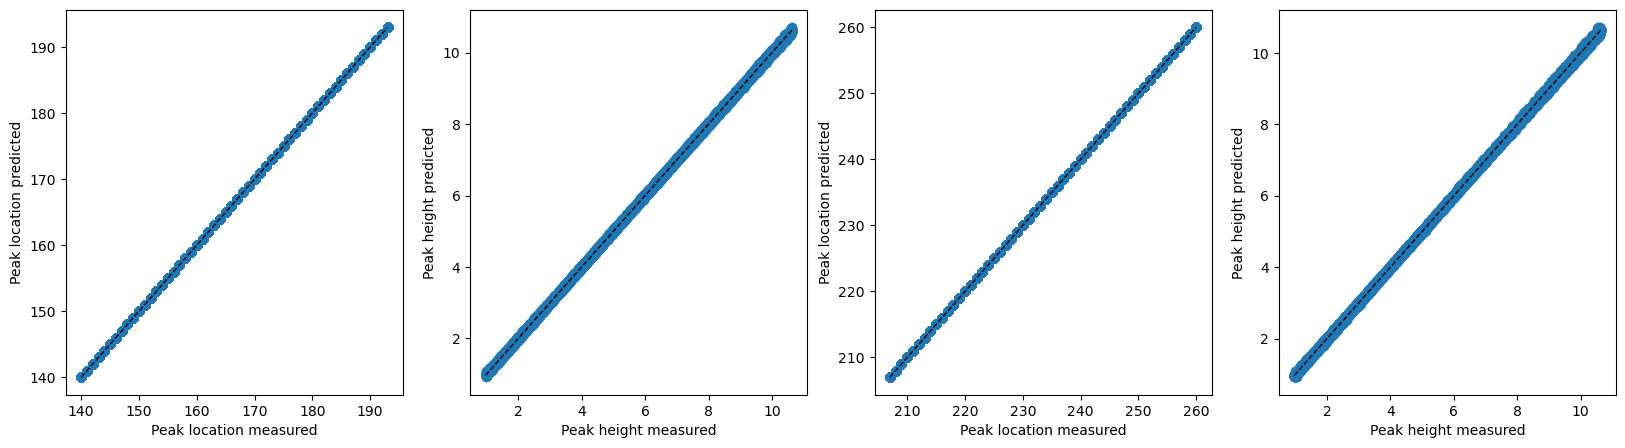

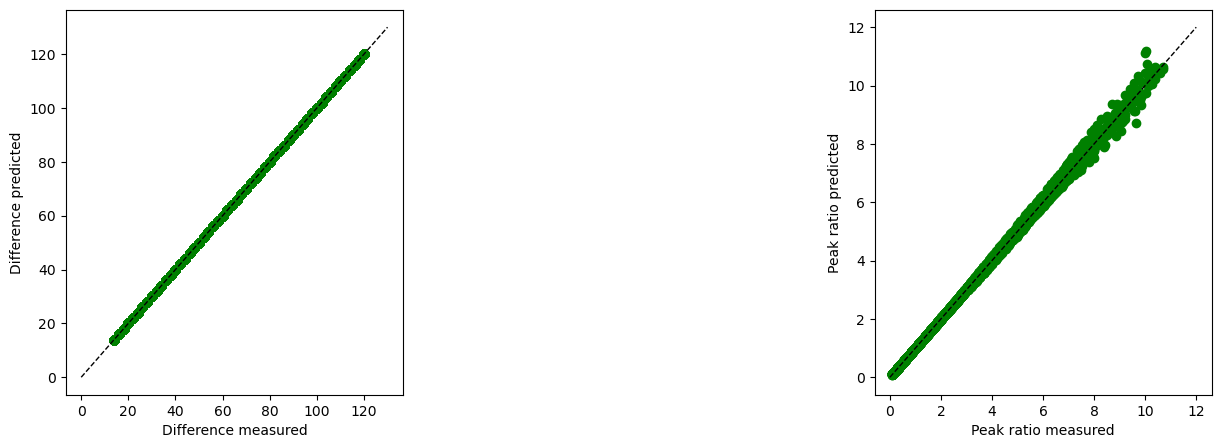

TEST SET DATASET
169/169 [==============================] - 3s 19ms/step
P1 RMSEC: 0.0
 P1 R^2: 1.0
H1 RMSEC: 0.016764744249644057
 H1 R^2: 0.9999646971320005
P2 RMSEC: 0.0
 P2 R^2: 1.0
H2 RMSEC: 0.020143210317117213
 H2 R^2: 0.9999472620163822


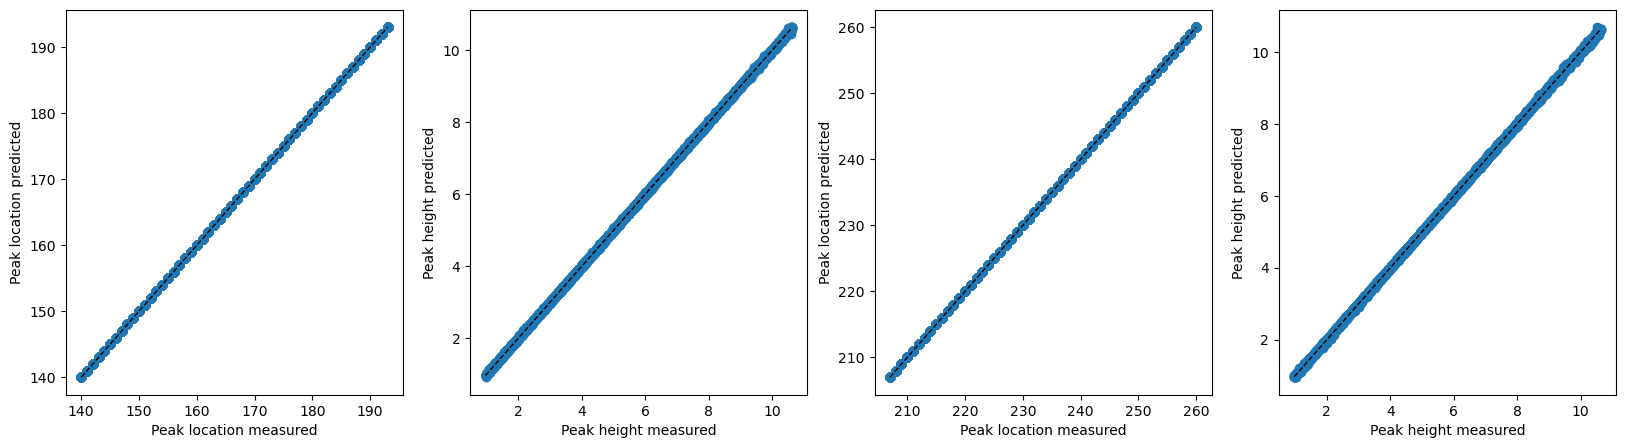

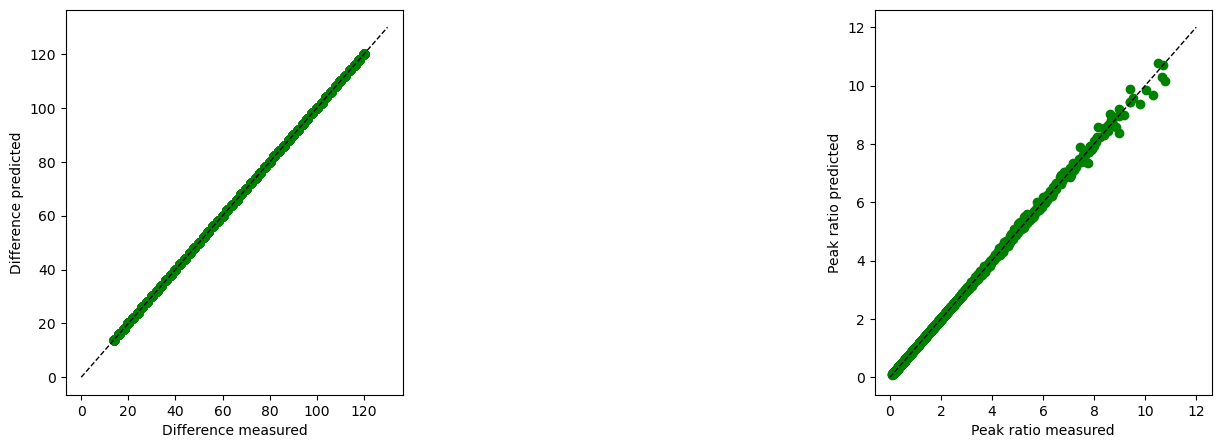

In [7]:
model.load_weights(filepath='best.tf')
    
test_model(model, dataset=(X_train, y_train), dataset_name='TRAIN SET')
test_model(model, dataset=(X_test, y_test), dataset_name='TEST SET')

In [7]:
noise1 = spio.loadmat('volt_sim_noise1.mat')
X_n1 = np.expand_dims(noise1['X'], axis=2)

X_train_n1, X_test_n1, y_train_n1, y_test_n1 = train_test_split(X_n1, noise1['y'], test_size=0.1, shuffle=True)
X_train_n1, X_val_n1, y_train_n1, y_val_n1 = train_test_split(X_train_n1, y_train_n1, test_size=0.1)

y_train_hot_n1 = prepare_y_vector(y_train_n1)
y_val_hot_n1 = prepare_y_vector(y_val_n1)


In [10]:
model_n1 = mkmodel()
model_n1.load_weights('best.tf')

tf.random.set_seed(33331)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.8, beta_2=0.9, decay=0.00001)
model_n1.compile(loss={'y': loss},
              optimizer=opt,
              run_eagerly=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    mode='min'
)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001, min_delta=1e-4, mode='min')
mcp1_save = tf.keras.callbacks.ModelCheckpoint('best_n1_new.tf', save_format='tf', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
mymodel=model_n1.fit(
    X_train_n1,
    y_train_hot_n1,
    batch_size=128,
    epochs=200,
    verbose=1,
    validation_data=(X_val_n1,y_val_hot_n1),
    callbacks=[mcp1_save, reduce_lr_loss] 
)

2024-01-01 14:31:00.358983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 14:31:00.359816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 14:31:00.360576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2024-01-01 14:31:01.091013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 14:31:01.091838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 14:31:01.092670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

342/342 [==============================] - ETA: 0s - loss: 3.8239

2024-01-01 14:31:34.673565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 14:31:34.674451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 14:31:34.675073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

342/342 [==============================] - 35s 94ms/step - loss: 3.8239 - val_loss: 1.1694 - lr: 5.0000e-05
Epoch 2/200
342/342 [==============================] - 31s 92ms/step - loss: 0.5226 - val_loss: 0.5015 - lr: 5.0000e-05
Epoch 3/200
342/342 [==============================] - 32s 93ms/step - loss: 0.3749 - val_loss: 0.2640 - lr: 5.0000e-05
Epoch 4/200
342/342 [==============================] - 31s 92ms/step - loss: 0.3140 - val_loss: 0.2472 - lr: 5.0000e-05
Epoch 5/200
342/342 [==============================] - 32s 93ms/step - loss: 0.2752 - val_loss: 0.1991 - lr: 5.0000e-05
Epoch 6/200
342/342 [==============================] - 31s 92ms/step - loss: 0.2385 - val_loss: 0.2437 - lr: 5.0000e-05
Epoch 7/200
342/342 [==============================] - 31s 91ms/step - loss: 0.2226 - val_loss: 0.1664 - lr: 5.0000e-05
Epoch 8/200
342/342 [==============================] - 31s 91ms/step - loss: 0.2069 - val_loss: 0.1669 - lr: 5.0000e-05
Epoch 9/200
342/342 [==============================]

In [13]:
model_n1.load_weights('./best_n1_new.tf')
tf.random.set_seed(33331)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00003, beta_1=0.8, beta_2=0.9, decay=0.00001)
model_n1.compile(loss={'y': loss},
              optimizer=opt,
              run_eagerly=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    mode='min'
)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001, min_delta=1e-4, mode='min')
mcp1_save = tf.keras.callbacks.ModelCheckpoint('best_n1_new2.tf', save_format='tf', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
mymodel=model_n1.fit(
    X_train_n1,
    y_train_hot_n1,
    batch_size=128,
    epochs=200,
    verbose=1,
    validation_data=(X_val_n1,y_val_hot_n1),
    callbacks=[mcp1_save, reduce_lr_loss] 
)

Epoch 1/200


2024-01-01 16:21:10.671574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 16:21:10.672583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 16:21:10.673293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

342/342 [==============================] - ETA: 0s - loss: 0.0927

2024-01-01 16:21:45.099958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 16:21:45.100596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 16:21:45.101398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

342/342 [==============================] - 37s 97ms/step - loss: 0.0927 - val_loss: 0.0566 - lr: 3.0000e-05
Epoch 2/200
342/342 [==============================] - 31s 90ms/step - loss: 0.0772 - val_loss: 0.0557 - lr: 3.0000e-05
Epoch 3/200
342/342 [==============================] - 33s 98ms/step - loss: 0.0795 - val_loss: 0.0826 - lr: 3.0000e-05
Epoch 4/200
342/342 [==============================] - 33s 95ms/step - loss: 0.0803 - val_loss: 0.1931 - lr: 3.0000e-05
Epoch 5/200
342/342 [==============================] - ETA: 0s - loss: 0.0799
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
342/342 [==============================] - 33s 95ms/step - loss: 0.0799 - val_loss: 0.0914 - lr: 3.0000e-05
Epoch 6/200
342/342 [==============================] - 33s 95ms/step - loss: 0.0574 - val_loss: 0.0353 - lr: 1.5000e-05
Epoch 7/200
342/342 [==============================] - 33s 95ms/step - loss: 0.0535 - val_loss: 0.0382 - lr: 1.5000e-05
Epoch 8/200
342/342 [========

In [24]:
model_n1.load_weights('./best_n1_new2.tf')
tf.random.set_seed(33331)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001, beta_1=0.8, beta_2=0.9, decay=0.00001)
model_n1.compile(loss={'y': loss},
              optimizer=opt,
              run_eagerly=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    mode='min'
)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, patience=3, verbose=1, min_lr=0.00000001, min_delta=1e-4, mode='min')
mcp1_save = tf.keras.callbacks.ModelCheckpoint('best_n1_new3.tf', save_format='tf', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
mymodel=model_n1.fit(
    X_train_n1,
    y_train_hot_n1,
    batch_size=128,
    epochs=50,
    verbose=1,
    validation_data=(X_val_n1,y_val_hot_n1),
    callbacks=[mcp1_save, reduce_lr_loss] 
)

Epoch 1/50


2024-01-01 22:34:53.040192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 22:34:53.041160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 22:34:53.041856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

342/342 [==============================] - ETA: 0s - loss: 0.0360

2024-01-01 22:35:26.230126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 22:35:26.231519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 22:35:26.232176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

342/342 [==============================] - 35s 94ms/step - loss: 0.0360 - val_loss: 0.0256 - lr: 1.0000e-05
Epoch 2/50
342/342 [==============================] - 31s 91ms/step - loss: 0.0361 - val_loss: 0.0219 - lr: 1.0000e-05
Epoch 3/50
342/342 [==============================] - 31s 90ms/step - loss: 0.0371 - val_loss: 0.0236 - lr: 1.0000e-05
Epoch 4/50
342/342 [==============================] - ETA: 0s - loss: 0.0361
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
342/342 [==============================] - 31s 90ms/step - loss: 0.0361 - val_loss: 0.0637 - lr: 1.0000e-05
Epoch 5/50
342/342 [==============================] - 31s 92ms/step - loss: 0.0276 - val_loss: 0.0239 - lr: 3.0000e-06
Epoch 6/50
342/342 [==============================] - 31s 92ms/step - loss: 0.0271 - val_loss: 0.0229 - lr: 3.0000e-06
Epoch 7/50
342/342 [==============================] - 31s 92ms/step - loss: 0.0278 - val_loss: 0.0286 - lr: 3.0000e-06
Epoch 8/50
342/342 [===============

train_n1 DATASET


2024-01-01 23:00:58.626081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 23:00:58.627004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 23:00:58.627654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1367/1367 [==============================] - 27s 20ms/step
P1 RMSEC: 0.022931081013588532
 P1 R^2: 0.9999978318713733
H1 RMSEC: 0.030701918079945358
 H1 R^2: 0.9998790250333986
P2 RMSEC: 0.017239802523171532
 P2 R^2: 0.9999987745424079
H2 RMSEC: 0.030626867747692552
 H2 R^2: 0.9998798909958801


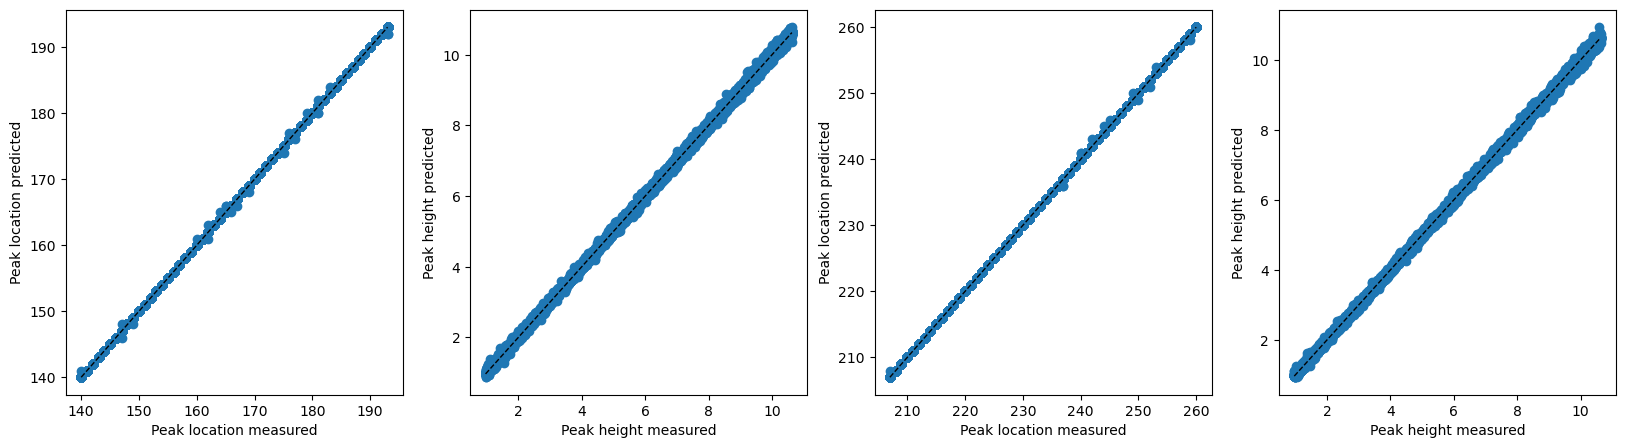

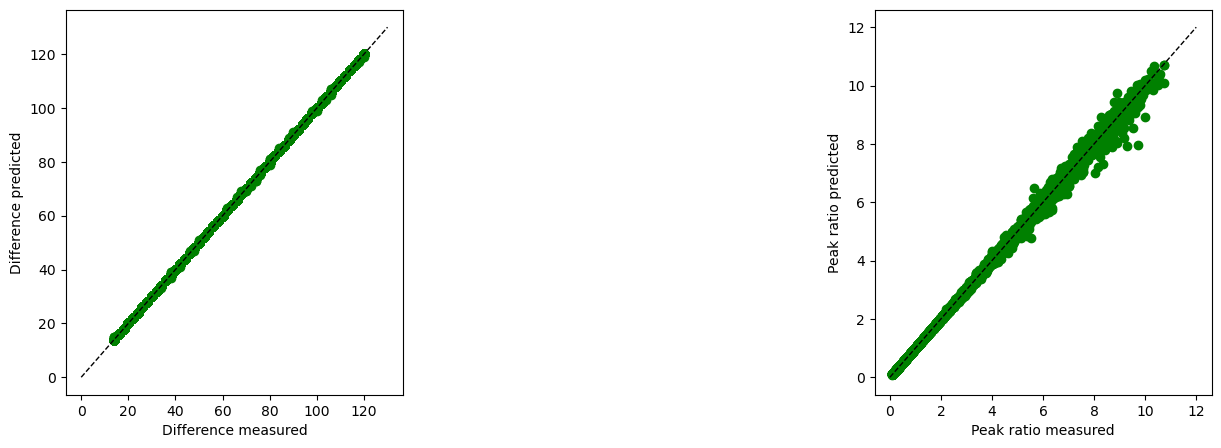

test_n1 DATASET
169/169 [==============================] - 3s 19ms/step
P1 RMSEC: 0.023570226039551584
 P1 R^2: 0.9999977411885675
H1 RMSEC: 0.031664907527160675
 H1 R^2: 0.9998687604629745
P2 RMSEC: 0.013608276348795434
 P2 R^2: 0.9999992472315751
H2 RMSEC: 0.03157200132618672
 H2 R^2: 0.999871064657166


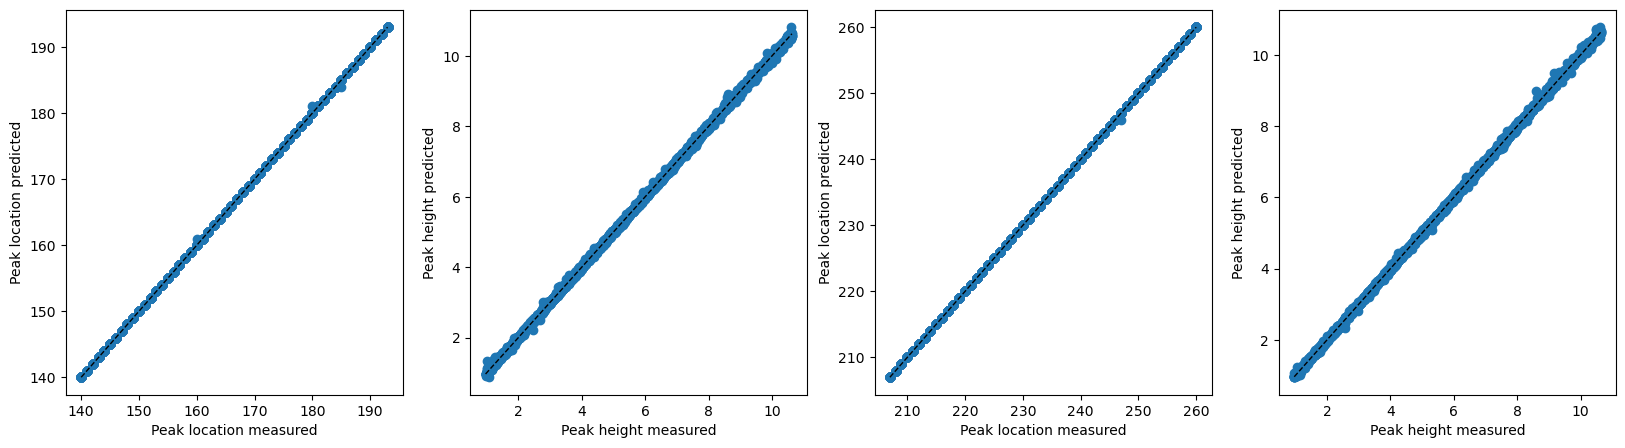

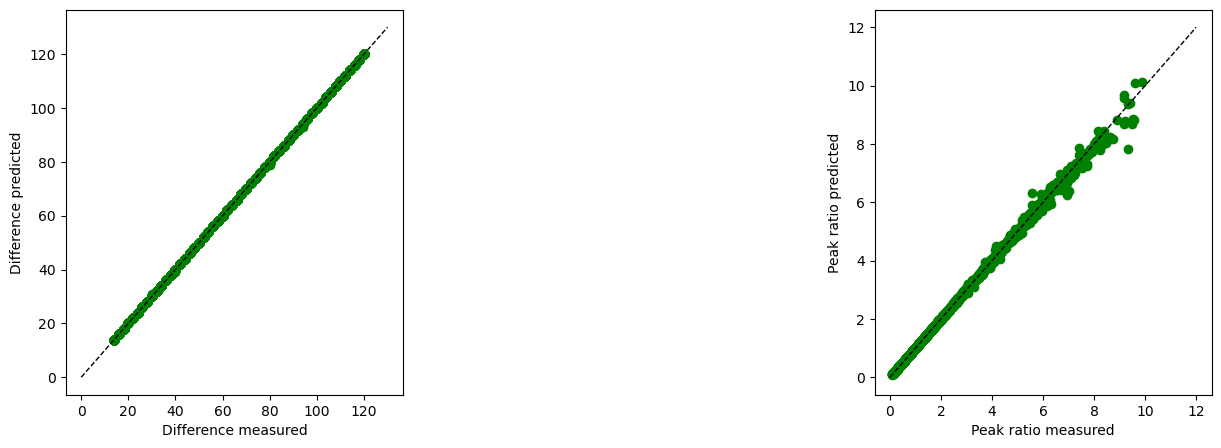

In [25]:
model_n1.load_weights(filepath='best_n1_new3.tf')
test_model(model_n1, (X_train_n1, y_train_n1), dataset_name='train_n1')
test_model(model_n1, (X_test_n1, y_test_n1), dataset_name='test_n1')

In [6]:
cafa1 = spio.loadmat('volt_exp_cafa.mat')
X_cafa = np.expand_dims(cafa1['X'], axis=2)

X_train_cafa, X_test_cafa, y_train_cafa, y_test_cafa = train_test_split(X_cafa, cafa1['y'], test_size=0.1, shuffle=True)
X_train_cafa, X_val_cafa, y_train_cafa, y_val_cafa = train_test_split(X_train_cafa, y_train_cafa, test_size=0.1)

y_train_hot_cafa = prepare_y_vector(y_train_cafa)
y_val_hot_cafa = prepare_y_vector(y_val_cafa)



In [17]:
model_cafa = mkmodel()
model_cafa.load_weights('./best_n1_new3.tf')

tf.random.set_seed(33331)
opt1 = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.8, beta_2=0.9, decay=0.00001)
model_cafa.compile(loss={'y': loss},
              optimizer=opt1,
              run_eagerly=False)

model_cafa.optimizer.learning_rate.assign(0.0001)
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    mode='min'
)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, patience=3, verbose=1, min_lr=0.00000001, min_delta=1e-4, mode='min')
mcp1_save = tf.keras.callbacks.ModelCheckpoint('best_cafa.tf', save_format='tf', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

cafa_hist = model_cafa.fit(
    X_train_cafa,
    y_train_hot_cafa,
    batch_size=128,
    epochs=250,
    verbose=1,
    validation_data=(X_val_cafa,y_val_hot_cafa),
    callbacks=[mcp1_save, reduce_lr_loss] 
)

2024-01-02 09:59:38.365964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-02 09:59:38.366789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-02 09:59:38.367516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2024-01-02 09:59:39.081112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-02 09:59:39.082044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-02 09:59:39.082685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

342/342 [==============================] - ETA: 0s - loss: 3.4456

2024-01-02 10:00:13.149006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-02 10:00:13.149755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-02 10:00:13.150527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

342/342 [==============================] - 36s 96ms/step - loss: 3.4456 - val_loss: 2.2120 - lr: 1.0000e-04
Epoch 2/250
342/342 [==============================] - 31s 92ms/step - loss: 1.1419 - val_loss: 1.3082 - lr: 1.0000e-04
Epoch 3/250
342/342 [==============================] - 31s 91ms/step - loss: 0.7985 - val_loss: 0.6249 - lr: 1.0000e-04
Epoch 4/250
342/342 [==============================] - 31s 91ms/step - loss: 0.6508 - val_loss: 1.0796 - lr: 1.0000e-04
Epoch 5/250
342/342 [==============================] - 32s 92ms/step - loss: 0.5749 - val_loss: 0.5164 - lr: 1.0000e-04
Epoch 6/250
342/342 [==============================] - 31s 91ms/step - loss: 0.5025 - val_loss: 0.5604 - lr: 1.0000e-04
Epoch 7/250
342/342 [==============================] - 31s 92ms/step - loss: 0.4712 - val_loss: 0.4548 - lr: 1.0000e-04
Epoch 8/250
342/342 [==============================] - 31s 91ms/step - loss: 0.4387 - val_loss: 0.5213 - lr: 1.0000e-04
Epoch 9/250
342/342 [==============================]

CAFA_TRAIN DATASET


2024-01-02 12:11:31.173189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-02 12:11:31.174161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-02 12:11:31.174800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1367/1367 [==============================] - 29s 20ms/step
P1 RMSEC: 0.14791648553863598
 P1 R^2: 0.9999288694358514
H1 RMSEC: 0.05043178913231043
 H1 R^2: 0.9995620901215272
P2 RMSEC: 0.11692602955606493
 P2 R^2: 0.9999554695360512
H2 RMSEC: 0.05206715746764203
 H2 R^2: 0.9995320738094428


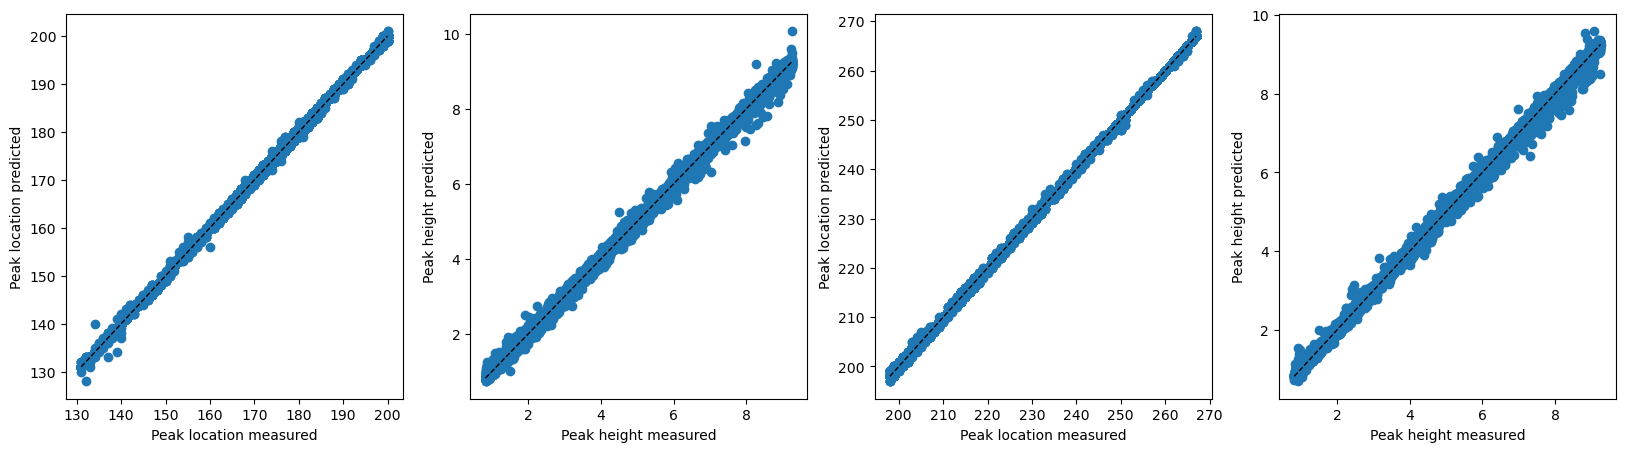

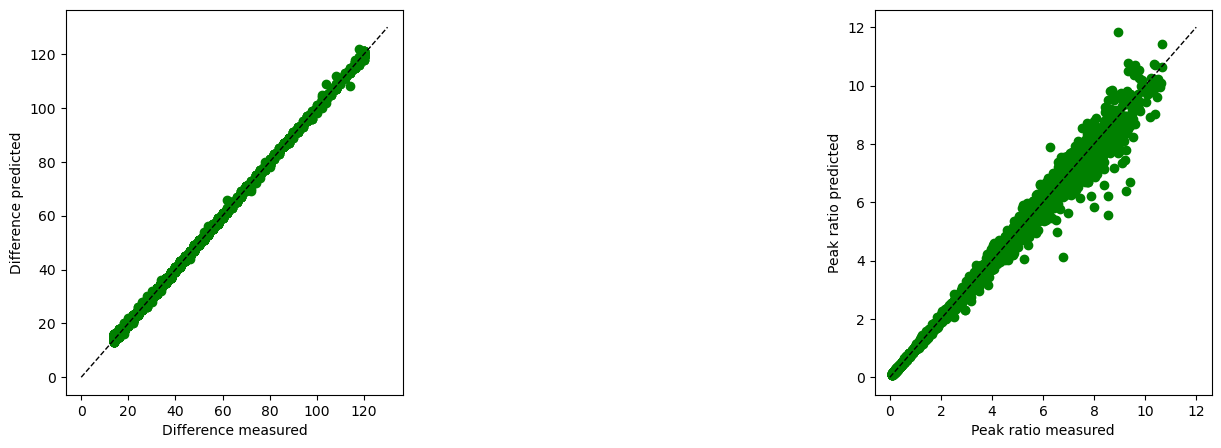

CAFA_TEST DATASET
169/169 [==============================] - 3s 20ms/step
P1 RMSEC: 0.17427096823731247
 P1 R^2: 0.9998979777691559
H1 RMSEC: 0.05114672157209066
 H1 R^2: 0.9995394760172209
P2 RMSEC: 0.12171612389003691
 P2 R^2: 0.9999521772523239
H2 RMSEC: 0.053843469577282976
 H2 R^2: 0.999493439241307


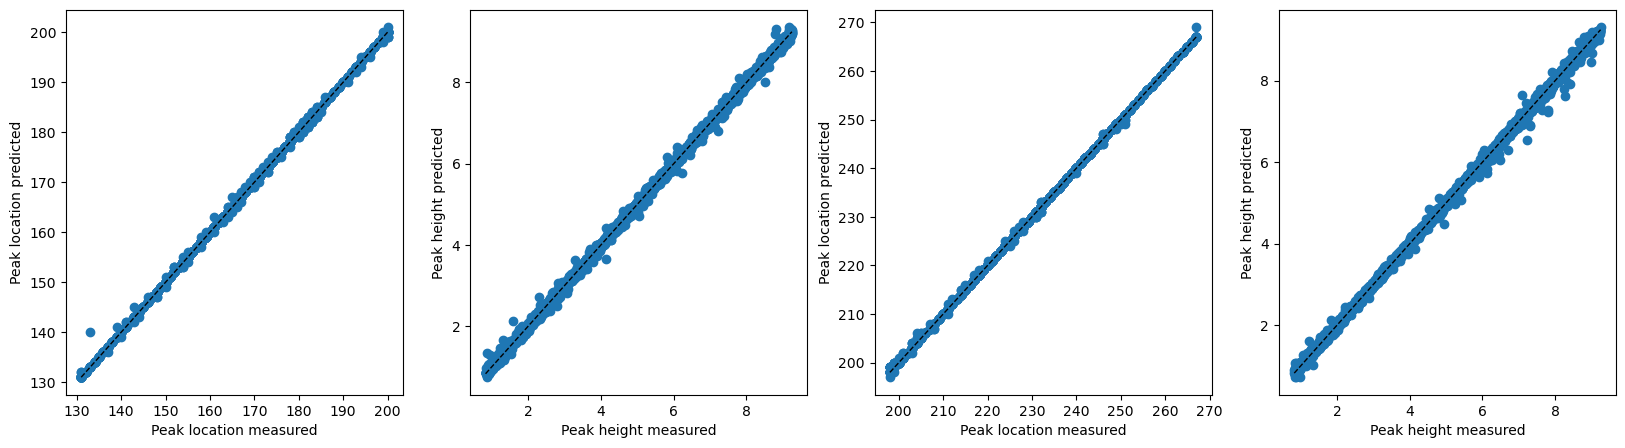

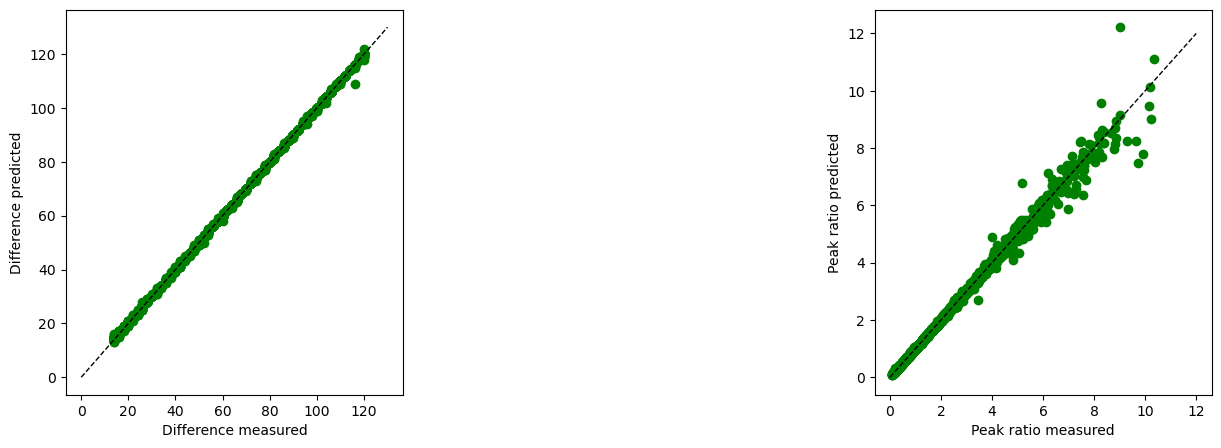

In [18]:
model_cafa.load_weights('./best_cafa.tf')
test_model(model_cafa, (X_train_cafa, y_train_cafa), dataset_name='CAFA_TRAIN')
test_model(model_cafa, (X_test_cafa, y_test_cafa), dataset_name='CAFA_TEST')

2024-02-04 18:58:47.030948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-04 18:58:47.032050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-04 18:58:47.032766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

CAFA_CAL DATASET


2024-02-04 18:58:47.628793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-04 18:58:47.629793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-04 18:58:47.630485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step
P1 RMSEC: 0.0
 P1 R^2: nan
H1 RMSEC: 0.0025745009387155697
 H1 R^2: 0.9981428742098841
P2 RMSEC: 0.0
 P2 R^2: nan
H2 RMSEC: 0.0021957345873806905
 H2 R^2: 0.9995879196021883


/home/fc/.conda/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/fc/.conda/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


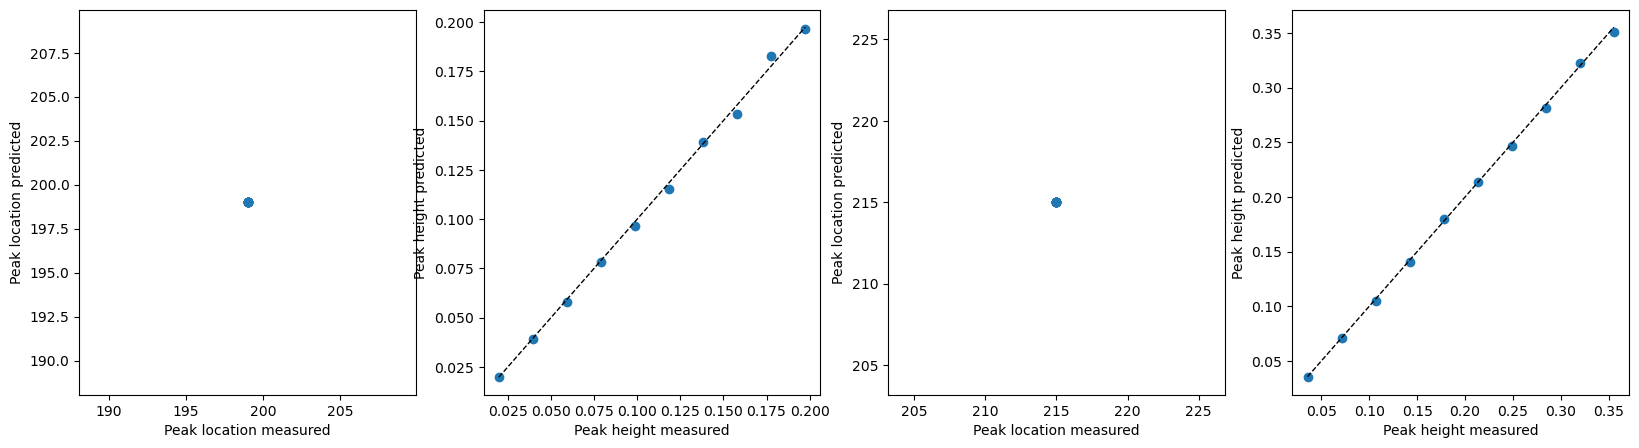

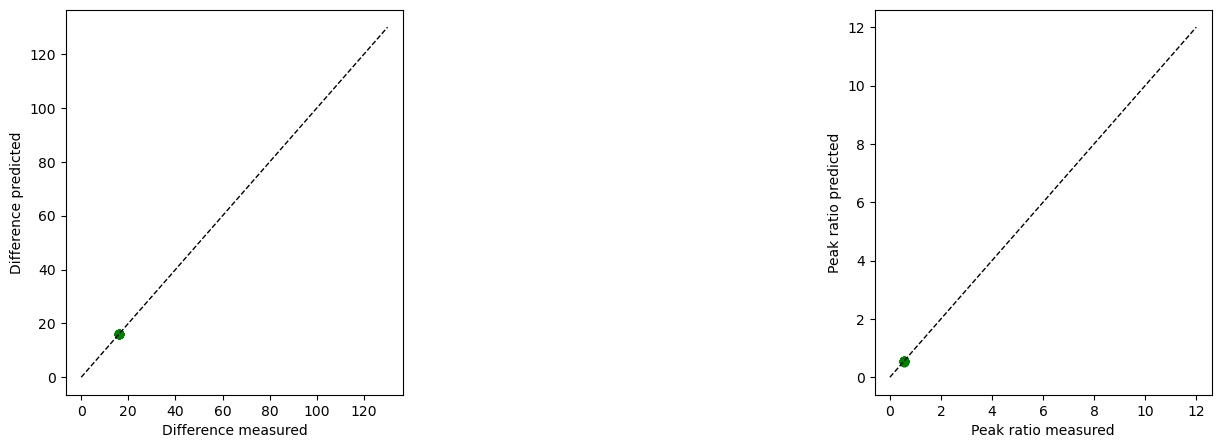

In [8]:
model_cafa = mkmodel()
model_cafa.load_weights('./best_cafa.tf')
cafa_cal = spio.loadmat('volt_exp_cafa_cal.mat')
X_cafa_cal = np.expand_dims(cafa_cal['Xkal'], axis=2)
y_cafa_cal = cafa_cal['ykal']
test_model(model_cafa, (X_cafa_cal, y_cafa_cal), dataset_name='CAFA_CAL')

In [9]:
def calc_calibration_params(test_model, dataset, dataset_name):
    from scipy import stats
    conc = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
    X_train, y_train = dataset
    print(f'{dataset_name} DATASET');
    pred_train = test_model.predict(X_train)
    pred_train = decode_output(pred_train)
    
    txts = ['P1', 'H1', 'P2', 'H2']
    regs = []
    vals = []
    concs = [conc, conc]
    for i in range(4):
      t = txts[i]
      if 'H' not in t:
            continue

      print(pred_train[:,i])
      print(f'{t} RMSEC:', np.sqrt(mean_squared_error(y_train[:,i],pred_train[:,i])))
      vals.append(pred_train[:,i])
      corr,_ = pearsonr(y_train[:,i],pred_train[:,i])
      print(f' {t} R^2:', corr**2)
      res = stats.linregress(conc,pred_train[:,i])
      regs.append(res)
      print(res)
    return regs, vals, concs

In [10]:
regs, vals, concs = calc_calibration_params(model_cafa, (X_cafa_cal, y_cafa_cal), dataset_name='CAFA_CAL')

CAFA_CAL DATASET
1/1 [==============================] - 0s 20ms/step
[0.01983911 0.03913838 0.05809413 0.07804307 0.09663831 0.11519547
 0.1390951  0.15312597 0.18264705 0.19657572]
H1 RMSEC: 0.0025745009387155697
 H1 R^2: 0.9981428742098841
LinregressResult(slope=1.9830682523774377, intercept=-0.0012295243640740444, rvalue=0.9990710055896349, pvalue=3.2549643022427243e-12, stderr=0.030242450157345186, intercept_stderr=0.0018764946835389928)
[0.03506124 0.07094027 0.10488113 0.14073335 0.17993297 0.21398105
 0.24667463 0.28177434 0.32264626 0.35095668]
H2 RMSEC: 0.0021957345873806905
 H2 R^2: 0.9995879196021883
LinregressResult(slope=3.540205363974426, intercept=4.68959410985792e-05, rvalue=0.9997939385704375, pvalue=7.886013159645883e-15, stderr=0.025413468388964175, intercept_stderr=0.001576864244598752)


In [11]:
from scipy import stats

In [12]:
data_real_calibration_CA = [0.0123, 0.0334, 0.0559, 0.0763, 0.0975, 0.1167, 0.1354, 0.1551, 0.1717, 0.1936, 0.2127]
conc = [0, 0.01, 0.02, 0.03, 0.04, 0.05 ,0.06 ,0.07 ,0.08, 0.09, 0.10]

In [13]:
ca_cal = stats.linregress(conc,data_real_calibration_CA)

In [14]:
ca_cal

LinregressResult(slope=1.987, intercept=0.015249999999999972, rvalue=0.9995837148682744, pvalue=3.5843853096060515e-15, stderr=0.01911712966071653, intercept_stderr=0.0011309846429665908)

In [15]:
data_real_calibration_FA = [0.0065, 0.0418, 0.0702, 0.1034, 0.1394, 0.1719, 0.2039, 0.2346, 0.2670, 0.2918, 0.3208]

In [16]:
fa_cal = stats.linregress(conc,data_real_calibration_FA)

In [17]:
fa_cal

LinregressResult(slope=3.171636363636364, intercept=0.009718181818181792, rvalue=0.9994290108659182, pvalue=1.4855412630534157e-14, stderr=0.03574185581522501, intercept_stderr=0.002114516705989141)

In [18]:
def plot_reg(conc, reg, expv, name):
    plt.figure(figsize=[4, 4])
    c = np.array([np.min(conc), np.max(conc)])
    v = c * reg.slope + reg.intercept
    plt.scatter(conc, expv)
    plt.plot(c, v, 'r')
    plt.xlabel(f'{name} / µM')
    plt.ylabel('I / µA')

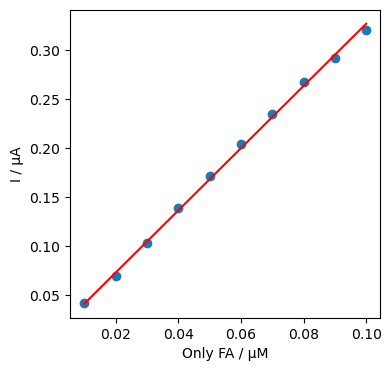

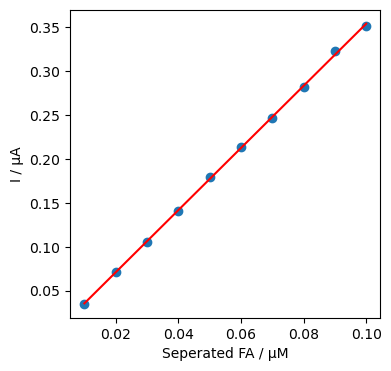

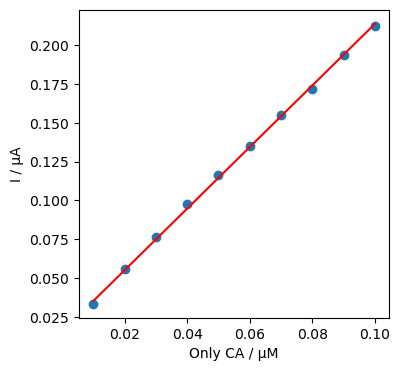

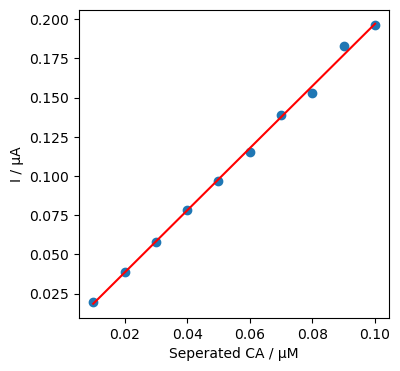

In [19]:
plot_reg(conc[1:], fa_cal, data_real_calibration_FA[1:], 'Only FA')

plot_reg(concs[1], regs[1], vals[1], 'Seperated FA')

plot_reg(conc[1:], ca_cal, data_real_calibration_CA[1:], 'Only CA')

plot_reg(concs[0], regs[0], vals[0], 'Seperated CA')